# HELICoiD Evaluation

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib qt
%matplotlib widget

In [2]:
import os
import sys
from pathlib import Path

src_dir = str(Path(os.getcwd()).parent / "src")
sys.path.insert(1, src_dir)
#os.environ["PYTHONPATH"] = src_dir

In [3]:
import data_loader
import calculate_concentr_diffs
from concentr_diffs_pathlength import *
from plotting import *
from mbll_functions import *
from utils import *
from mcs_function import *
import config
import pickle
from ray import tune
import matplotlib.pyplot as plt
from inspect import signature
from tqdm.notebook import tqdm
import time
import pandas

## Setup

load the m-parameters for the Jaques models

In [4]:
tissue_types_short = ["gray matter", "tumor", "blood vessel"]
tissue_types_long = ["general"] + tissue_types_short

In [5]:
with open(config.m_params_path, "rb") as f:
    jacques_m_params, _, _, _ = pickle.load(f)

create MCS-Attenuation Object

In [6]:
A_mcs = SimulationAttenuation(config.mcs_func_path)

Loaded data with 50000.0 photons and 30 values for mu_s.


In [7]:
mcs_sparsity = 18 # results in 30 wavelengths

Load  data

In [8]:
loader = data_loader.DataLoaderHELICOID(
    config.dataset_dir,
    wavelength_left_cut=520,
    wavelength_right_cut=900
)

mu_a_matrix = loader.absorption_coefs(
    use_diff_oxycco=False,
    use_water_and_fat=True
)

delta_A_gt_img = loader.get_attenuation_change("020-01")
A_gt_img = loader.get_attenuation("020-01")

foreground_mask = (loader.label_map != 4)
labeled_mask = (loader.label_map != 0)
labeled_foreground_mask = labeled_mask & foreground_mask

/home/leon_ivan/miniconda3/envs/nonlinear-fit/lib/python3.11/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


In [9]:
loader.wavelengths[::mcs_sparsity]

array([520.        , 533.09090909, 546.18181818, 559.27272727,
       572.36363636, 585.45454545, 598.54545455, 611.63636364,
       624.72727273, 637.81818182, 650.90909091, 664.        ,
       677.09090909, 690.18181818, 703.27272727, 716.36363636,
       729.45454545, 742.54545455, 755.63636364, 768.72727273,
       781.81818182, 794.90909091, 808.        , 821.09090909,
       834.18181818, 847.27272727, 860.36363636, 873.45454545,
       886.54545455, 899.63636364])

In [10]:
len(loader.wavelengths[::mcs_sparsity])

30

In [11]:
gray_matter_mcs_pathlength_data = np.loadtxt(config.pl_dir / "gray_matter_mcs.txt")
blood_vessel_mcs_pathlength_data = np.loadtxt(config.pl_dir / "blood_vessel_pure_mcs.txt")
tumor_mcs_pathlength_data = np.loadtxt(config.pl_dir / "tumor_mcs.txt")

In [12]:
lengths = tuple()
for mcs_data in (gray_matter_mcs_pathlength_data, tumor_mcs_pathlength_data, blood_vessel_mcs_pathlength_data):
    pathlength = np.interp(loader.wavelengths, mcs_data[:, 0], mcs_data[:, 4] / 10) # convert to cm
    # notice the minus: mean scatterlength = mean pathlength - ((mean scattercount)/mu_s)
    scatterlength = mcs_data[:, 4] / 10 - mcs_data[:, 5] / (mcs_data[:, 2] * 10)
    scatterlength = np.interp(loader.wavelengths, mcs_data[:, 0], scatterlength)
    lengths += (pathlength, scatterlength)

gray_matter_pathlength, gray_matter_scatterlength, tumor_pathlength, tumor_scatterlength, blood_vessel_pathlength, blood_vessel_scatterlength = lengths

In [13]:
gray_matter_baseline_attenuation = np.interp(
    loader.wavelengths,
    gray_matter_mcs_pathlength_data[:, 0],
    -np.log(gray_matter_mcs_pathlength_data[:, 3])
)

blood_vessel_baseline_attenuation = np.interp(
    loader.wavelengths,
    blood_vessel_mcs_pathlength_data[:, 0],
    -np.log(blood_vessel_mcs_pathlength_data[:, 3])
)

tumor_baseline_attenuation = np.interp(
    loader.wavelengths,
    tumor_mcs_pathlength_data[:, 0],
    -np.log(tumor_mcs_pathlength_data[:, 3])
)

Create NLLS + MCS objects that will be used several times

In [14]:
params = {
    "wavelengths": loader.wavelengths,
    "mu_a_matrix": mu_a_matrix,
    "tissue_types": ["gray matter", "tumor", "blood vessel"],
    "pathlength": [gray_matter_pathlength, tumor_pathlength, blood_vessel_pathlength],
    "scatterlength": [gray_matter_scatterlength, tumor_scatterlength, blood_vessel_scatterlength],
    "baseline_b": [ data_loader.DataLoader.tissue_parameters[tissue][1][1] for tissue in tissue_types_short],
    "g": [data_loader.DataLoader.tissue_parameters[tissue][-1] for tissue in tissue_types_short],
}

A_mbll_mcs = A_mbll_fit(
    baseline_attenuation=[
        gray_matter_baseline_attenuation,
        tumor_baseline_attenuation,
        blood_vessel_baseline_attenuation
    ],
    baseline_concentrations = [
        data_loader.DataLoader.tissue_parameters[tissue][0] for tissue in tissue_types_short
    ],
    baseline_a = [
        data_loader.DataLoader.tissue_parameters[tissue][1][0] for tissue in tissue_types_short
    ],
    **params
)

A_mbll_mcs_delta = A_mbll_fit_delta(**params)

Load reference parameters obtained through hyperparameter search

In [15]:
with open(config.reference_params_path, "rb") as f:
    hyperparams = pickle.load(f)

In [16]:
config.reference_params_path

PosixPath('/home/leon_ivan/data/evaluation/reference_params.pickle')

## Backward Test - HELICoiD

Plot HeliCoiD spectum of gray matter pixel, and pixel obtained by MCS + NLLS forward model for gray matter literature values.

In [17]:
A_mcs_predicted = A_mcs.A_concentrations(
    loader.wavelengths,
    mu_a_matrix,
    data_loader.DataLoader.tissue_parameters["gray matter"][0],
    *data_loader.DataLoader.tissue_parameters["gray matter"][1]
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


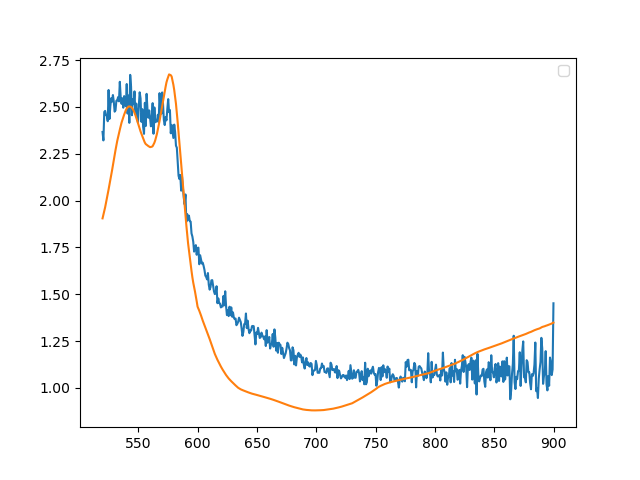

In [18]:
plot_spectra([A_gt_img[:, loader.reference_pixel[0], loader.reference_pixel[1]], A_mcs_predicted + 0.4] , loader.wavelengths)

### Absolute vs Difference

Create mask of all labeled pixels, without background pixels

In [19]:
# every labeled pixel without background
print(np.count_nonzero(labeled_foreground_mask))

7010


In [20]:
# (models, parameters, spectrum)
concentrations_absolute_diff = np.zeros((6, 6, np.count_nonzero(labeled_foreground_mask)))

#### Jacques

Optimization using absolute spectra

In [21]:
res, errors = concentr_fit_nonlinear_multiple_tissues_concurrent(
    A_gt_img[:, labeled_foreground_mask],
    loader.label_map[labeled_foreground_mask], # only contains 1, 2, 3 (normal, tumor, blood)
    loader.wavelengths,
    mu_a_matrix,
    A_jacques_blood_fraction,
    const_vals=[
        jacques_m_params["gray matter"], #normal
        jacques_m_params["tumor"], #tumor
        jacques_m_params["blood vessel"]  #blood
    ],
    variables_bool_arr=np.array([True] * 8 + [False] * 3),
    left_bounds = np.array([0] * 8),
    right_bounds = np.array([1, 1, 0.05, 0.05, 1, 1, 100, 7]),
    update_init=True,
    constraint=None,
    init_vals=concentrations_to_blood_fraction(
        np.concatenate(data_loader.DataLoader.tissue_parameters["gray matter"][:2])
    ),
    num_processes=20,
    progress_bar=True
)

concentrations_absolute_diff[0, :, :] = blood_fraction_to_concentrations(res[:6, :])

000


0
00

1
0
0
1
10

10
0
00
1


0
2
2210

2
1
0


10
1

1
01

113


323


121


213


12

42
02


13

23
4

22

243


2
5
4
1
3
4
32
3
6

543


2
5
5
3333
0

4
5


7
352
4


6
44
4

458
6


64

47

164


35

65

598
35



54
65


25

72

7
6106

7
6

9
676


77
4
4
8

55113
8



3
6810


9777

8


6
712

5
4
11
9
95
10
8
13

488

6

868


12
107

10119


58

91479

9


65

96
13

1511

79

8
10
1214

6610

7

11
9
10
10
12
716107



81311


101215


10
9
88

1317147


1112
11
81111




13
711

1512
168


13
1411
10
99

12

1218

121416


9
15139


17
88
13

12
1217

131110

15

1019

14
189

161413


131018
12


16
14
201113


1914

10
14917


1715915



19
1114
1120


151218


13102114


15
15

16
16
1811
1221


15
1210

20
13
141510
16

11
22

17
16
211719


13
1617
18
13

231216


1419
22

1112
1617


1511

20
1914
1823


14
20131312

17
24


18
1722

18
16
171224
15


19
152115


14192520
21



1813
13

1425

19
1716

16
20
1815
231918



22222616


14

2615
21
20

1717
20

142

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



234242


193

217252241


184
267
245199

245
203180
196235


215206176


222197194
268242



203
253
243
236
246
185218
243195


204181
246
198

200
223
207244
269204197



219
216
237244

205254

186182
247220199



238245224270

247206

196


205201

245
255221208177


248
198

217183271207239200

246


246


187
248
197225
202199


208
184249
247
222178


209
201272

206249198


188209
226256
240

250

248223247

179

202185200


250
210
218
227241

257203273


249
248
224251

199207210


189
203
228251
249

211180
258
219
242
274

208250201


200
186225

204211
204190
252


275
251181
250243
212252

209


229201

205
226253276

202252212



220
191
205187
213230
259


202
253
244277

206
213
253
231
214
227254
254

203
221260

182
207
192278

255232245251



188206

214255
228

254210

215
203204

208
261
279222

256246
229

215
193183
233
209

207204

216
189
205256257

262
252

280223

234
247216210230



184
205257

217
255
208194
206

263211
258

224248

235
253258
206

190
21

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Optimize using difference spectrum

In [22]:
res, errors = concentr_fit_nonlinear_multiple_tissues_concurrent(
    delta_A_gt_img[:, labeled_foreground_mask],
    loader.label_map[labeled_foreground_mask], # only contains 1, 2, 3 (unlabeled, normal, tumor, blood)
    loader.wavelengths,
    mu_a_matrix,
    A_jacques_blood_fraction,
    const_vals=[
        jacques_m_params["gray matter"], #normal
        jacques_m_params["tumor"], #tumor
        jacques_m_params["blood vessel"]  #blood
    ],
    ref_vals=hyperparams["020-01", "Jacques, specific"][1],
    variables_bool_arr=([True] * 8 + [False] * 3),
    left_bounds = np.array([0] * 8),
    right_bounds = np.array([1, 1, 0.05, 0.05, 1, 1, 100, 7]),
    update_init=True,
    constraint=None,
    init_vals=concentrations_to_blood_fraction(
        np.concatenate(data_loader.DataLoader.tissue_parameters["gray matter"][:2])
    ),
    num_processes=20,
    progress_bar=True
)

concentrations_absolute_diff[1, :, :] = blood_fraction_to_concentrations(res[:6, :])

0
0
0
00

0
1
0
0
0
101
00

0


00

0010



0
10
1

1
2112
1
1



12

121


21
11


1
3
122


2
223


21
22


2
342

32


323


243


33

23
2
4
33
3

345



34
4

45

4
5
3
344


4
543


5
5343



56654




4
4
556

54
4


66

5
7
755


664

4
7
76


5
65

68

5
88

7
6
877

6
57


9
65
7
9
69

76
8


6
7
610

9
78
8
7
9

68
1087



10
8
78867


5


9
11
11108

7

108

911
710


129
8
8

911
99


116

1110

712

910

91013
9


1012

812
12
13

9
98
11

12
1410
13
10
10118
10


11

14
10713


1215

9
912

1311

13
14
11
1111

151014
14


1413

10131016

12
11


11
15
12
1215

12
1215

1416

1411
13

1116
11

151217


916

1312
138


1615
15

131612


1317
1812


121417


17
131614


1617

1418

14
15
9191813



181317

1310


14
17
1713

1515

1520
19

1615
10

18
18
141819


16
142114

14
19

1416

1620
1119
19
171116




2019

15
18
15
17
15
2120
22
17

2118

17
1216
1720


202022
12

18
15

161819


23
21
19
231718

21
21
1619


1719

1813

221822

2424
2113



1620

19
15
20
1420
2

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




247

263196
246

178
243250208

218

236209

223239248
247170

208

176186


222197

264
254
244251
237224
248179
177



204209
187
210

219
249
209
223265

240252

225245

249
171178
205198


211
255250

180
253220

188226

241266250


238
246
210
179
254
251
199
227256251
242172


206

181180
239
267211189



252
212228
247252


200257

255
253212207210

173


253224190
201213181

268

240

221
256243248



258
229202

182208241

269
174
254

254214191


257244249
182


203213

242
225209222

259

258
255
270230211175



243
245255
260250183



204226192


183
214
210256
259
215

223
244
271212

227
215184245205


246
216257
261


211
231
184
247251224


216256217


193272
258

260
206
213
262
176
246
212
248218232228



185
207257

273
259
185263225
261

249

252
247
214
213
208
229177

194
274219258233217
264




262
250186

260253248

226
186

265209

214
215220
275

234
249178259
195

187263
230

218

215
210
266235

261254
187

250
227216

216179276

264
236231
221219



262267

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



#### NLLS + MCS (Skipped, due to very long runtime)

In [31]:
res, errors = concentr_fit_nonlinear_multiple_tissues_concurrent(
    A_gt_img[::mcs_sparsity, labeled_foreground_mask],
    loader.label_map[labeled_foreground_mask], # only contains 0, 1, 2, 3 (unlabeled, normal, tumor, blood)
    loader.wavelengths[::mcs_sparsity],
    mu_a_matrix[::mcs_sparsity, :],
    A_mcs.A_blood_fraction,
    jacobian=A_mcs.jacobian_blood_fraction,
    variables_bool_arr=([True] * 8),
    left_bounds = np.array([0] * 8),
    right_bounds = np.array([1, 1, 0.05, 0.05, 1, 1, 100, 7]),
    update_init=True,
    constraint=None,
    init_vals=concentrations_to_blood_fraction(
        np.concatenate(data_loader.DataLoader.tissue_parameters["gray matter"][:2])
    ),
    num_processes=30,
    progress_bar=True
)

concentrations_absolute_diff[2, :, :] = blood_fraction_to_concentrations(res[:6, :])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
1
1
0
0
1
1
1
0
0
0
1
0
1
1
0
1
2
1
1
0
0
1
20

1
1
1
2
2
2
2
0
2
2
2
0
1
3
2
2
2
2
1
1
3
1
1
3
3
4
1
2
3
1
1
2
2
3
3
3
2
4
3
1
2
1
5
1
3
3
4
2
3
2
1
4
2
4
2
4
2
4
2
4
3
4
5
3
6
3
5
2
4
2
3
3
2
3
6
5
3
4
5
6
2
5
4
3
2
3
4
4
5
7
7
3
4
3
3
6
44

3
5
6
3
5
8
4
6
5
4
7
6
7
3
4
5
4
3
4
5
4
5
5
5
4
5
6
5
8
4
5
5
6
3
8
5
4
6
6
6
7
7
5
5
9
7
6
4
6
6
6
4
6
7
6
6
5
7
4
6
7
6
8
8
6
5
8
9
10
8
7
7
7
7
8
7
7
9
7
5
9
9
5
6
7
7
8
7
8
9
8
10
6
11
9
7
910

7
10
8
7
8
8
8
8
9
5
10
11
8
5
8
9
10
11
8
6
8
10
6
9
10
9
8
12
9
9
8
11
7
12
9
9
8
11
10
11
9
6
10
12
9
10
9
10
11
6
9
10
9
12
7
1210

11
11
7
9
10
13
12
11
13
10
11
10
13
11
10
12
7
14
10
8
8
7
11
13
1112

10
1013

118

5
14
12
13
11
13
11
1115

10
11
12
8
14
14
11
12
9
15
12
9
13
12
14
12
16
14
12
12
13
11
9
14
15
12
13
12
11
14
13
16
15
13
8
13
13
13
13
6
14
15
14
15
17
13
9
10
14
16
16
9
12
14
15
16
14
13
14
12
18
12
17
14
9
15
10
17
14
15
17
10
15
14
16
11
17
14
15
19
10
15
16
15
15
12
7
10
15
18
16
11
13

Optimize using difference spectrum

In [32]:
res, errors = concentr_fit_nonlinear_multiple_tissues_concurrent(
    A_gt_img[::mcs_sparsity, labeled_foreground_mask],
    loader.label_map[labeled_foreground_mask], # only contains 0, 1, 2, 3 (unlabeled, normal, tumor, blood)
    loader.wavelengths[::mcs_sparsity],
    mu_a_matrix[::mcs_sparsity, :],
    A_mcs.A_blood_fraction,
    jacobian=A_mcs.jacobian_blood_fraction,
    variables_bool_arr=([True] * 8),
    ref_vals=hyperparams["020-01", "NLLS + MCS"][1],
    left_bounds = np.array([0] * 8),
    right_bounds = np.array([1, 1, 0.05, 0.05, 1, 1, 100, 7]),
    update_init=True,
    constraint=None,
    init_vals=concentrations_to_blood_fraction(
        np.concatenate(data_loader.DataLoader.tissue_parameters["gray matter"][:2])
    ),
    num_processes=30,
    progress_bar=True
)

concentrations_absolute_diff[3, :, :] = blood_fraction_to_concentrations(res[:6, :])

0
0
0
0
0
0
0
0
0
1
0
0
0
0
2
0
00

0
0
01

0
0
1
0
0
0
0
1
11

0
1
0
1
1
1
0
1
2
1
2
1
1
0
0
1
2
1
1
3
1
2
1
1
1
1
1
3
2
3
2
1
1
1
1
2
2
2
1
2
2
2
2
1
2
4
2
3
4
2
3
3
2
4
2
1
2
5
2
22

2
2
3
3
2
3
3
3
2
2
4
3
4
3
3
3
3
2
3
5
4
3
4
2
5
3
4
3
4
6
45

4
4
3
6
3
3
4
5
4
3
4
4
5
3
7
4
3
4
3
5
5
4
6
4
6
5
5
4
3
4
8
5
3
6
6
5
5
45

5
6
7
5
5
9
5
5
7
7
6
6
6
5
5
4
7
4
5
3
7
4
8
10
4
8
4
6
6
6
8
6
7
5
6
6
7
4
5
11
7
6
9
6
6
8
6
8
9
8
57

7
5
6
12
6
8
9
10
6
9
7
7
7
7
8
9
5
13
10
6
5
7
107

7
6
7
4
8
9
8
7
5
7
8
9
11
8
14
8
8
10
9
6
7
7
9
8
11
10
7
8
9
10
9
15
11
11
9
8
7
8
9
8
10
11
10
10
12
6
16
10
12
9
8
12
5
10
9
8
9
11
9
8
7
11
17
10
13
6
8
13
11
12
12
11
9
9
14
12
12
6
13
11
10
8
10
10
13
9
15
9
14
6
11
10
12
910

13
12
12
14
11
18
10
7
15
7
13
11
9
12
19
7
14
13
12
13
10
11
10
20
8
9
14
13
13
16
14
11
11
10
16
11
14
11
12
10
21
10
15
15
78

13
10
15
8
12
11
22
12
15
16
13
11
11
16
8
23
15
14
17
12
11
14
16
14
17
11
24
12
9
14
13
12
18
16
18
11
13
12
17
9
13
25
9
19
17
16
14
17
15
12
8
17

#### MBLL + MCS

In [33]:
concentrations_absolute_diff[4, :, (loader.label_map[labeled_foreground_mask] == 1)] = A_mbll_mcs.concentr_fit(
    A_gt_img[:, (loader.label_map == 1)],
    "gray matter"
)[:6, :].T

concentrations_absolute_diff[4, :, (loader.label_map[labeled_foreground_mask] == 2)] = A_mbll_mcs.concentr_fit(
    A_gt_img[:, (loader.label_map == 2)],
    "tumor"
)[:6, :].T

concentrations_absolute_diff[4, :, (loader.label_map[labeled_foreground_mask] == 3)] = A_mbll_mcs.concentr_fit(
    A_gt_img[:, (loader.label_map == 3)],
    "blood vessel"
)[:6, :].T

# we compute concentration changes for every pixel as reference, and average results
for tissue_idx, tissue in enumerate(tissue_types_short, start=1):
    tissue_pixels = list(zip(*np.nonzero(loader.label_map == tissue_idx)))
    for ref_pixel_idx, ref_pixel_coords in tqdm(list(enumerate(tissue_pixels))):
        delta_A_gt_img_tmp = A_gt_img[:, (loader.label_map == tissue_idx)] - A_gt_img[:, *ref_pixel_coords, None]
        concentrations_absolute_diff[5, :6, (loader.label_map[labeled_foreground_mask] == tissue_idx)] += A_mbll_mcs_delta.concentr_fit_delta(
            delta_A_gt_img_tmp,
            tissue
        )[:6, :].T
        
    concentrations_absolute_diff[5, :, (loader.label_map[labeled_foreground_mask] == tissue_idx)] /= len(tissue_pixels)


  0%|          | 0/1842 [00:00<?, ?it/s]

  0%|          | 0/3655 [00:00<?, ?it/s]

  0%|          | 0/1513 [00:00<?, ?it/s]

In [34]:
# (tissue, models, parameters), models incl. GT
concentrations_absolute_diff_average = np.empty((3, 7, 6))

for tissue_idx, tissue in enumerate(tissue_types_short, start=1):
    concentrations_absolute_diff_average[tissue_idx-1, 0, :] = data_loader.DataLoader.tissue_parameters[tissue][0]
    concentrations_absolute_diff_average[tissue_idx-1, 1:, :] = np.average(concentrations_absolute_diff[:, :, (loader.label_map[labeled_foreground_mask] == tissue_idx)], axis=-1)


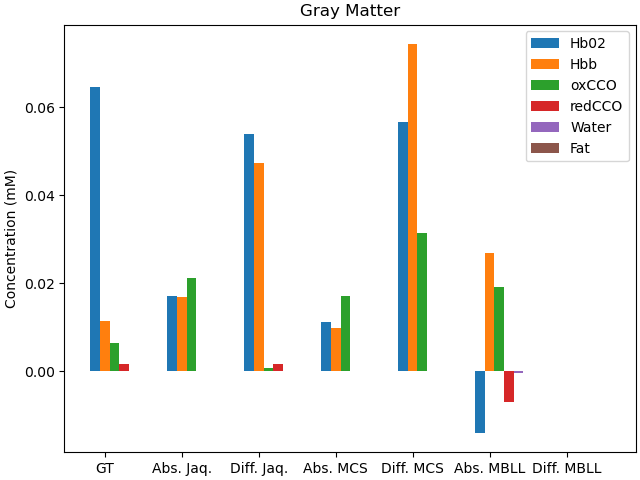

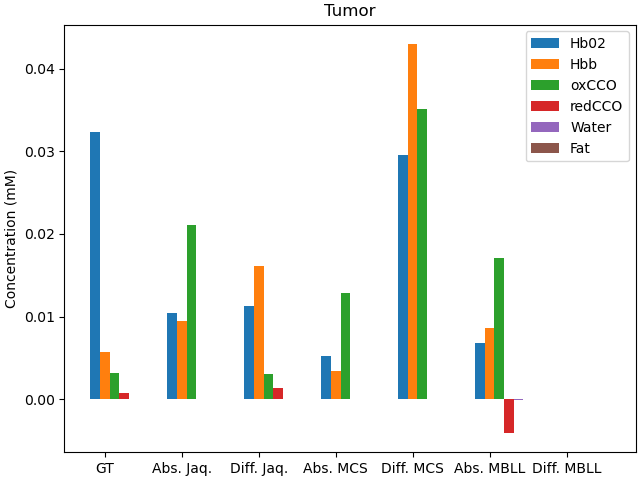

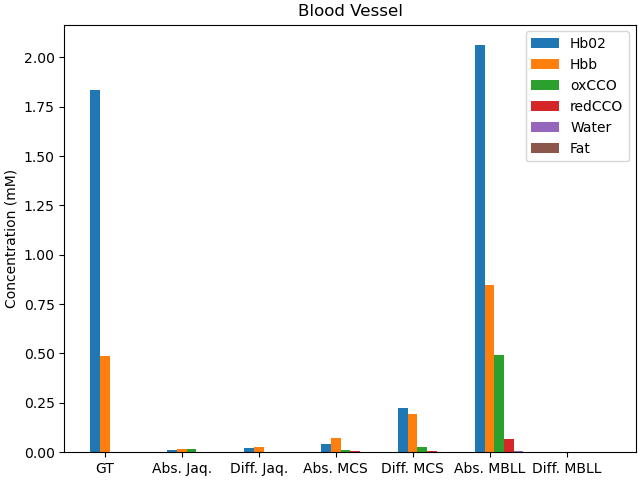

In [38]:
plot_concentrations_bar(concentrations_absolute_diff_average, ["Gray Matter", "Tumor", "Blood Vessel"], ["GT", "Abs. Jaq.", "Diff. Jaq.", "Abs. MCS", "Diff. MCS", "Abs. MBLL", "Diff. MBLL"], ["Hb02", "Hbb", "oxCCO", "redCCO", "Water", "Fat"])

In [51]:
with open(config.eval_dir / "helicoid/concentrations_absolute_diff.pickle", "wb+") as f:
    pickle.dump(concentrations_absolute_diff, f)

with open(config.eval_dir / "helicoid/concentrations_absolute_diff_average.pickle", "wb+") as f:
    pickle.dump(concentrations_absolute_diff_average, f)

### Concentration Reconstruction

In [59]:
fully_reconstructed_image_id = "020-01"
image_ids = ["020-01", "012-01", "015-01"]
num_images = len(image_ids)

Define additional MBLL backwards models

In [60]:
baseline_attenuations_diffusion, baseline_pathlengths_diffusion, baseline_scatterlengths_diffusion = [], [], []
for tissue_type in tissue_types_short:
    params = (
        loader.wavelengths,
        mu_a_matrix,
        data_loader.DataLoader.tissue_parameters[tissue_type][0],
        *data_loader.DataLoader.tissue_parameters[tissue_type][1],
        *data_loader.DataLoader.tissue_parameters[tissue_type][-2:],
    )
    baseline_attenuations_diffusion.append(A_carp_concentrations(*params)[:, 0])
    baseline_pathlengths_diffusion.append(A_carp_pathlength(*params)[:, 0]),
    baseline_scatterlengths_diffusion.append(A_carp_scatterlength(*params)[:, 0])

A_mbll_carp = A_mbll_fit_delta(
    loader.wavelengths,
    mu_a_matrix,
    tissue_types_short,
    baseline_pathlengths_diffusion,
    baseline_scatterlengths_diffusion,
    [data_loader.DataLoader.tissue_parameters[tissue][1][1] for tissue in tissue_types_short],
    [data_loader.DataLoader.tissue_parameters[tissue][2] for tissue in tissue_types_short]
)

In [61]:
A_mbll_mcs_gm_pl_const = A_mbll_fit_delta(
    loader.wavelengths,
    mu_a_matrix,
    ["general"],
    [gray_matter_baseline_attenuation],
    [gray_matter_scatterlength],
    [data_loader.DataLoader.tissue_parameters["gray matter"][1][1]],
    [data_loader.DataLoader.tissue_parameters["gray matter"][2]]
)

A_mbll_const = A_mbll_fit_delta(
    loader.wavelengths,
    mu_a_matrix,
    ["general"],
    np.ones((1, len(loader.wavelengths))),
    np.ones((1, len(loader.wavelengths))),
    [data_loader.DataLoader.tissue_parameters["gray matter"][1][1]],
    [data_loader.DataLoader.tissue_parameters["gray matter"][2]]
)

In [62]:
backwards_models_mbll = {
    A_mbll_mcs_delta,
    A_mbll_carp
}

backwards_models_mbll_tissue_independent = {
    A_mbll_mcs_gm_pl_const,
    A_mbll_const
}

In [63]:
backwards_models_nonlinear = {
    "Jacques, specific":
    (
        A_jacques_blood_fraction,
        {"const_vals": [list(jacques_m_params[tissue]) for tissue in tissue_types_long]}
    ),
    "Jacques, general":
    (
        A_jacques_blood_fraction, 
        {"const_vals": [list(jacques_m_params["general"])] * len(tissue_types_long)}
    ),
    "Carp":
    (
        A_carp_blood_fraction, 
        {
            "const_vals": [data_loader.DataLoader.tissue_parameters[tissue][-2:] for tissue in (["gray matter"] + tissue_types_short)],
        }
    ),
    "NLLS + MCS":
    (A_mcs.A_blood_fraction, {
        "jacobian": A_mcs.jacobian_blood_fraction
    })
}

In [64]:
num_mbll_models = len(backwards_models_mbll)
num_mbll_models_tissue_independent = len(backwards_models_mbll_tissue_independent)
num_nonlinear_models = len(backwards_models_nonlinear)
loader.load_data(fully_reconstructed_image_id)
reconstructed_img_num_spectrum = np.prod(loader.get_attenuation(fully_reconstructed_image_id).shape[1:])

# (models, params, spectrum)
reconstructed_concentrations_full_image = np.ones((
    num_mbll_models + num_mbll_models_tissue_independent + num_nonlinear_models,
    8,
    reconstructed_img_num_spectrum
), dtype=float) * np.nan

# (models)
reconstruction_time = np.zeros(num_mbll_models + num_nonlinear_models + num_mbll_models_tissue_independent)

# (tissues, models, images, params)
#reconstructed_concentrations_average = np.empty((len(tissue_types), num_mbll_models + num_nonlinear_models, num_images, 8))


tissue_ctr = np.zeros((len(image_ids), 5), dtype=int)
for image_idx, image_id in enumerate(image_ids):
    loader.load_data(image_id)
    cur_label_map = loader.label_map
    labels, label_cts = np.unique(cur_label_map, return_counts=True)
    tissue_ctr[image_idx, labels.astype(int)] = label_cts

# tissue pixel counts summed over all images
tissue_ctr_summed = np.sum(tissue_ctr, axis=0, dtype=int)

# inhomogenous array
# first index indexes tissue
# after that the indices are (models, params, num_spectra)
# where num_spectra is the number of pixels of tissue type from all images of interest
reconstructed_concentrations_labeled = []
for tissue_idx in [1, 2, 3]:
    reconstructed_concentrations_labeled.append(
        np.empty((num_mbll_models + num_nonlinear_models, 8, tissue_ctr_summed[tissue_idx]), dtype=float)
    )


In [65]:
tissue_ctr

array([[115105,   1842,   3655,   1513,   2625],
       [204418,   4516,    855,   8697,   1685],
       [177662,   1251,   2046,   4089,    696]])

MBLL - models, with tissue specific parameters

In [68]:
for image_idx, image_id in enumerate(image_ids):
    A_gt_img = loader.get_attenuation(image_id)   
    for model_idx, mbll_model in tqdm(list(enumerate(backwards_models_mbll))):
        for tissue_idx, tissue in enumerate(tissue_types_short, start=1):
            if image_id == fully_reconstructed_image_id and tissue == "gray matter":
                # additionally compute concentrations for unlabeled region,
                # use default gray matter pixel as reference pixel
                delta_A_gt_img = loader.get_attenuation_change(image_id, reference_label="gray matter")
                reconstruction_time[model_idx] = -time.monotonic()
                res = mbll_model.concentr_fit_delta(
                    delta_A=delta_A_gt_img[:, (loader.label_map == 0)],
                    tissue_type="gray matter"
                )
                reconstruction_time[model_idx] += time.monotonic()
                reconstructed_concentrations_full_image[model_idx, :7, np.flatnonzero(loader.label_map == 0)] = res.T
            
            reconstructed_concentrations_tmp = np.zeros((7, tissue_ctr[image_idx, tissue_idx], tissue_ctr[image_idx, tissue_idx]))
            tissue_pixels = list(zip(*np.nonzero(loader.label_map == tissue_idx)))
            time_val = -time.monotonic()
            for ref_idx, ref_coords in tqdm(list(enumerate(tissue_pixels))):
                delta_A_gt_img = A_gt_img[:, (loader.label_map == tissue_idx)] - A_gt_img[:, *ref_coords, None]
                res = mbll_model.concentr_fit_delta(
                    delta_A=delta_A_gt_img,
                    tissue_type=tissue
                )
                reconstructed_concentrations_tmp[:, ref_idx, :] = res
            time_val += time.monotonic()
            if image_id == fully_reconstructed_image_id:
                reconstruction_time[model_idx] += time_val / tissue_ctr[image_idx, tissue_idx]
            assert len(tissue_pixels) == tissue_ctr[image_idx, tissue_idx]
            cur_tissue_spectrum_idx = np.sum(tissue_ctr[:image_idx, tissue_idx])
            reconstructed_concentrations_labeled[tissue_idx-1][model_idx, :7, cur_tissue_spectrum_idx:(cur_tissue_spectrum_idx+tissue_ctr[image_idx, tissue_idx])] = np.average(reconstructed_concentrations_tmp, axis=1) #average over reference pixels
            if image_id == fully_reconstructed_image_id:
                # for image reconstruction, we only use one pixel within tissue as reference
                reconstructed_concentrations_full_image[model_idx, :7, np.flatnonzero(loader.label_map == tissue_idx)] = reconstructed_concentrations_tmp[:, loader.reference_pixel_tissue_ctr, :].T  

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1842 [00:00<?, ?it/s]

  0%|          | 0/3655 [00:00<?, ?it/s]

  0%|          | 0/1513 [00:00<?, ?it/s]

  0%|          | 0/1842 [00:00<?, ?it/s]

  0%|          | 0/3655 [00:00<?, ?it/s]

  0%|          | 0/1513 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4516 [00:00<?, ?it/s]

  0%|          | 0/855 [00:00<?, ?it/s]

  0%|          | 0/8697 [00:00<?, ?it/s]

  0%|          | 0/4516 [00:00<?, ?it/s]

  0%|          | 0/855 [00:00<?, ?it/s]

  0%|          | 0/8697 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1251 [00:00<?, ?it/s]

  0%|          | 0/2046 [00:00<?, ?it/s]

  0%|          | 0/4089 [00:00<?, ?it/s]

  0%|          | 0/1251 [00:00<?, ?it/s]

  0%|          | 0/2046 [00:00<?, ?it/s]

  0%|          | 0/4089 [00:00<?, ?it/s]

Old version of cell above. Should do the same, but for fewer pixels.

In [ ]:
num_ref_pixels = 100

In [ ]:
for image_idx, image_id in enumerate(image_ids):
    A_gt_img = loader.get_attenuation(image_id)    
    for model_idx, mbll_model in tqdm(list(enumerate(backwards_models_mbll))):
        for tissue_idx, tissue in enumerate(tissue_types_short, start=1):
            if image_id == fully_reconstructed_image_id and tissue == "gray matter":
                # additionally compute concentrations for unlabeled region,
                # use default gray matter pixel as reference pixel
                delta_A_gt_img = loader.get_attenuation_change(image_id, reference_label="normal")
                res = mbll_model.concentr_fit_delta(
                    delta_A=delta_A_gt_img[:, (loader.label_map == 0)],
                    tissue_type=tissue
                )
                reconstructed_concentrations_full_image[model_idx, :7, (loader.label_map.reshape(-1) == 0)] = res.T
            
            # reconstruct parameters for all pixels of tissue, using all pixels of same tissue type as reference
            num_pixels_per_tissue = tissue_ctr[image_idx, tissue_idx]
            #(params, ref-spectrum, spectrum)
            reconstructed_concentrations_tmp = np.zeros((7, num_ref_pixels, num_pixels_per_tissue))
            ref_pixels = np.zeros_like(loader.label_map, dtype=bool)
            ref_pixels[np.unravel_index(np.flatnonzero(loader.label_map == tissue_idx)[:num_ref_pixels], shape=loader.label_map.shape)] = True
            delta_A_gt_img = A_gt_img[:, None, (loader.label_map == tissue_idx)] - A_gt_img[:, ref_pixels, None]
            res = mbll_model.concentr_fit_delta(
                delta_A=delta_A_gt_img,
                tissue_type=tissue
            )
            if image_id == fully_reconstructed_image_id:
                # for image reconstruction, we only use one pixel within tissue as reference
                reconstructed_concentrations_full_image[model_idx, :7, np.flatnonzero(loader.label_map == tissue_idx)] = res[:, loader.reference_pixel_tissue_ctr, :].T
            
            reconstructed_concentrations_labeled[tissue_idx-1][model_idx, :7, :] = np.average(res, axis=1)
            

Nonlinear models

In [73]:
for image_idx, image_id in enumerate(image_ids):
    delta_A_gt_img = loader.get_attenuation(image_id)    
    labeled_foreground_mask = (loader.label_map != 0) & (loader.label_map != 4)
    for model_idx, model_str in tqdm(list(enumerate(backwards_models_nonlinear.keys(), start=len(backwards_models_mbll)))):
        delta_A_gt_img_tmp, wavelengths_tmp, mu_a_matrix_tmp = delta_A_gt_img, loader.wavelengths, mu_a_matrix
        model_func = backwards_models_nonlinear[model_str][0]
        
        if "NLLS" in model_str and "MCS" in model_str:
            delta_A_gt_img_tmp, wavelengths_tmp, mu_a_matrix_tmp = delta_A_gt_img[::mcs_sparsity, :], loader.wavelengths[::mcs_sparsity], mu_a_matrix[::mcs_sparsity, :]

        if image_id == fully_reconstructed_image_id:
                reconstruction_time[model_idx] = -time.monotonic()
                res, errors = concentr_fit_nonlinear_multiple_tissues_concurrent(
                    delta_A_gt_img_tmp[:, loader.label_map != 4],
                    loader.label_map[loader.label_map != 4],
                    wavelengths_tmp,
                    mu_a_matrix_tmp,
                    model_func,
                    variables_bool_arr=[True] * 8 + [False] * (len(signature(model_func).parameters) - 5),
                    left_bounds = np.array([0] * 8),
                    right_bounds = np.array([1, 1, 0.05, 0.05, 1, 1, 100, 7]),
                    update_init=True,
                    constraint=None,
                    init_vals=concentrations_to_blood_fraction(
                        np.concatenate(data_loader.DataLoader.tissue_parameters["gray matter"][:2])
                    ),
                    ref_vals=hyperparams[image_id, model_str][1],
                    num_processes=30,
                    **backwards_models_nonlinear[model_str][1]
                )
                reconstruction_time[model_idx] += time.monotonic()
                res = blood_fraction_to_concentrations(res)
                reconstructed_concentrations_full_image[model_idx, :, np.flatnonzero(loader.label_map != 4)] = res.T
                for tissue_idx in [1, 2, 3]:
                    cur_tissue_idx = np.sum(tissue_ctr[:image_idx, tissue_idx])
                    reconstructed_concentrations_labeled[tissue_idx-1][model_idx, :, cur_tissue_idx:(cur_tissue_idx+tissue_ctr[image_idx, tissue_idx])] = res[:, (loader.label_map[loader.label_map != 4] == tissue_idx)]
        else:
            res, errors = concentr_fit_nonlinear_multiple_tissues_concurrent(
                delta_A_gt_img_tmp[:, labeled_foreground_mask],
                loader.label_map[labeled_foreground_mask],
                wavelengths_tmp,
                mu_a_matrix_tmp,
                model_func,
                variables_bool_arr=([True] * 8) + ([False] * (len(signature(model_func).parameters) - 5)),
                left_bounds=np.array([0]*8),
                right_bounds=np.array([1, 1, 0.05, 0.05, 1, 1, 100, 7]),
                update_init=True,
                constraint=None,
                init_vals=concentrations_to_blood_fraction(
                    np.concatenate(data_loader.DataLoader.tissue_parameters["gray matter"][:2])
                ),
                ref_vals=hyperparams[image_id, model_str][1],
                num_processes=30,
                **backwards_models_nonlinear[model_str][1]
            )
            res = blood_fraction_to_concentrations(res)
            for tissue_idx in [1, 2, 3]:
                cur_tissue_idx = np.sum(tissue_ctr[:image_idx, tissue_idx])
                reconstructed_concentrations_labeled[tissue_idx-1][model_idx, :, cur_tissue_idx:(cur_tissue_idx+tissue_ctr[image_idx,tissue_idx])] = res[:, (loader.label_map[labeled_foreground_mask] == tissue_idx)]


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Tissue independent MBLL models
(only image reconstruction)

In [74]:
delta_A_gt_img = loader.get_attenuation_change(fully_reconstructed_image_id)
for model_idx, model in tqdm(list(enumerate(backwards_models_mbll_tissue_independent, start=(num_mbll_models + num_nonlinear_models)))):
    res = model.concentr_fit_delta(
        delta_A=delta_A_gt_img[:, loader.label_map != 4],
        tissue_type="general"
    )

    reconstructed_concentrations_full_image[model_idx, :7, np.flatnonzero(loader.label_map != 4)] = res.T

  0%|          | 0/2 [00:00<?, ?it/s]

In [75]:
with open(config.eval_dir/"helicoid/reconstructed_concentrations_full_image.pickle", "wb+") as f:
    pickle.dump(reconstructed_concentrations_full_image, f)

In [ ]:
with ope

Compute statistics

First data for bar plot: Per Tissue average over all spectra

In [76]:
# (tissues, models, params)
bar_plot_data = np.zeros((3, num_mbll_models + num_nonlinear_models, 6), dtype=float)

for tissue_idx in [1, 2, 3]:
    bar_plot_data[tissue_idx-1] = np.average(reconstructed_concentrations_labeled[tissue_idx-1][:, :6, :], axis=-1)

Now the prediction error for the appendix.
For nonlinear models, for every tissue we take the data from the bar plots compute squared error of (averaged, in previous step) parameters to literature values. For the tissue average, average these, weighted by the number of pixels per tissue type. For MBLL models the tissue weights have to be squared, since we computed average over all reference pixels.

For MBLL we do the same, but don't substract any literature values.

In [77]:
# (models, tissue+1)
prediction_error_table = np.empty(
    (
        num_nonlinear_models + num_mbll_models,
        4 # three tissue types + one column for average over all tissues
    )
)

for tissue_idx, tissue in enumerate(tissue_types_short, start=1):
    prediction_error_table[:num_mbll_models, tissue_idx-1] = np.sqrt(np.sum(bar_plot_data[tissue_idx-1, :num_mbll_models, :6]**2, axis=-1))
    prediction_error_table[num_mbll_models:, tissue_idx-1] = np.sqrt(np.sum((bar_plot_data[tissue_idx-1, num_mbll_models:, :6] - 
        data_loader.DataLoader.tissue_parameters[tissue][0])**2, axis=-1))



prediction_error_table[:num_mbll_models, 3] = np.average(
    prediction_error_table[:num_mbll_models, :3],
    axis=1,
    weights=tissue_ctr_summed[1:4]**2
)

prediction_error_table[num_mbll_models:, 3] = np.average(
    prediction_error_table[num_mbll_models:, :3],
    axis=1,
    weights=tissue_ctr_summed[1:4]
)

In [78]:
df = pandas.DataFrame(prediction_error_table)
df.index = ["MBLL MCS", "MBLL Carp"] + list(backwards_models_nonlinear.keys())
df.columns = ["GM", "tumor", "blood vessel", "avg"]
print(df)

                             GM         tumor  blood vessel           avg
MBLL MCS           1.308245e-17  3.704404e-17  1.018056e-15  6.894058e-16
MBLL Carp          7.127102e-17  7.755285e-17  5.709218e-16  4.067315e-16
Jacques, specific  5.500918e-01  8.068108e-01  1.176531e+00  9.239149e-01
Jacques, general   4.721563e-01  4.713298e-01  1.532275e+00  1.004520e+00
Carp               6.810452e-01  3.994714e-01  1.462624e+00  1.008821e+00
NLLS + MCS         5.463555e-01  5.682353e-01  1.621428e+00  1.091462e+00


Store the data.

In [80]:
with open(config.eval_dir/"helicoid/prediction_error_df.pickle", "wb+") as f:
    pickle.dump(df, f)

### Diagrams

#### Images

To visualize MBLL images, literature values are added to concentration-change values.

In [81]:
image_data = reconstructed_concentrations_full_image.copy()
for tissue_idx, tissue in enumerate(tissue_types_short, start=1):
    image_data[:num_mbll_models, :7, :] += np.concatenate(data_loader.DataLoader.tissue_parameters[tissue][:2])[None, :7, None]

loader.load_data(fully_reconstructed_image_id)
image_data = image_data[:, :6, :].reshape(image_data.shape[0], 6, *loader.label_map.shape)

/home/leon_ivan/miniconda3/envs/nonlinear-fit/lib/python3.11/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


#### Bar plot

append literature values

In [82]:
literature_bar_data = np.empty((bar_plot_data.shape[0], 1, 6))
for tissue_idx, tissue in enumerate(tissue_types_short, start=1):
    literature_bar_data[tissue_idx-1:, 0, :] = data_loader.DataLoader.tissue_parameters[tissue][0]

bar_plot_data = np.concatenate((literature_bar_data, bar_plot_data), axis=1)

In [83]:
with open(config.eval_dir/"helicoid/bar_plot_data.pickle", "wb+") as f:
    pickle.dump(bar_plot_data, f)

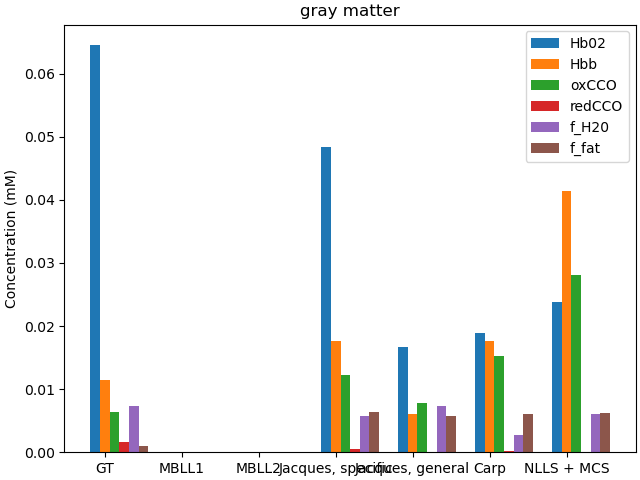

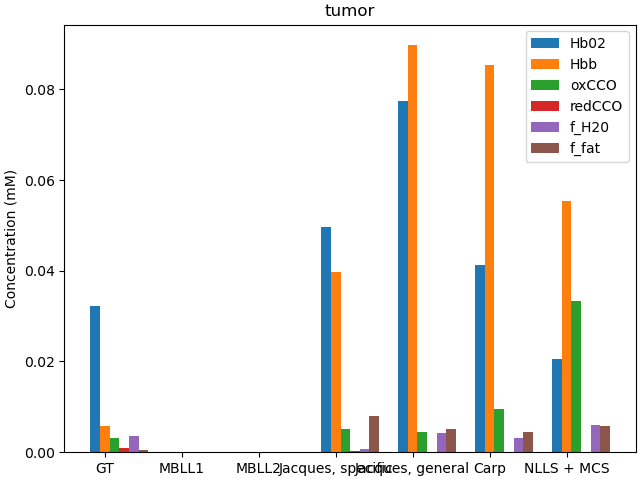

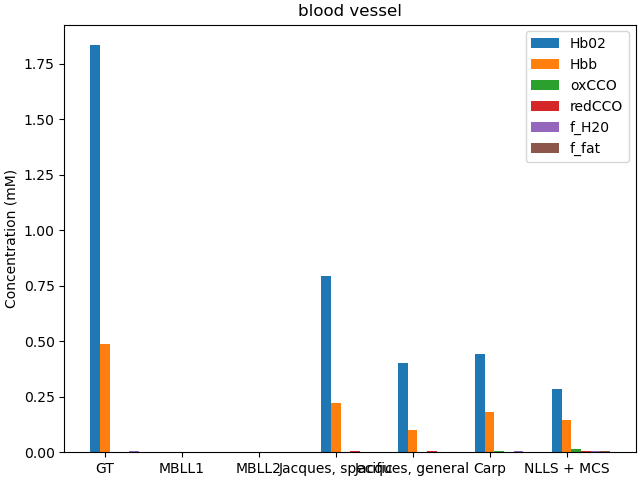

In [84]:
plot_concentrations_bar(
    bar_plot_data,
    tissue_types_short,
    ["GT"] + ["MBLL1", "MBLL2"] + list(backwards_models_nonlinear.keys()),
    ["Hb02", "Hbb", "oxCCO", "redCCO", "f_H20", "f_fat"]
)

Reconstruction times

In [85]:
df = pandas.DataFrame(reconstruction_time.T)
df.index = ["MBLL MCS", "MBLL Carp", "MBLL, const. GM PL", "MBLL ones PL"] + list(backwards_models_nonlinear.keys())
df.columns = ["Runtime [s]"]
print(df)

                    Runtime [s]
MBLL MCS               0.220542
MBLL Carp              0.214777
MBLL, const. GM PL    68.468879
MBLL ones PL          50.245157
Jacques, specific     70.900727
Jacques, general    9492.682005
Carp                   0.000000
NLLS + MCS             0.000000


In [86]:
with open(config.eval_dir/"helicoid/times_df.pickle", "wb+") as f:
    pickle.dump(df, f)